In [1]:
import numpy as np
import pandas as pd
import skimage.io
import matplotlib.pyplot as plt
import sklearn
import skimage.feature
import skimage.transform
import os
from glob import glob
import re
%matplotlib inline

In [2]:
folder = os.listdir('./project-data/data')
print(folder)

['BearHead', 'CatHead', 'ChickenHead', 'CowHead', 'DeerHead', 'DogHead', 'DuckHead', 'EagleHead', 'ElephantHead', 'HumanHead', 'LionHead', 'MonkeyHead', 'MouseHead', 'Natural', 'PandaHead', 'PigeonHead', 'RabbitHead', 'SheepHead', 'TigerHead', 'WolfHead']


In [3]:
all_path = []
for f in folder:
    all_path.append(glob('./project-data/data/{}/*.jpg'.format(f)))
img_all = []
for r in range(len(all_path)):
    for c in range(len(all_path[r])):
        img_all.append(all_path[r][c].replace("\\", "/"))
img_all[:5], len(img_all)

(['./project-data/data/BearHead/bearfrontal0001.jpg',
  './project-data/data/BearHead/bearfrontal0002.jpg',
  './project-data/data/BearHead/bearfrontal0003.jpg',
  './project-data/data/BearHead/bearfrontal0004.jpg',
  './project-data/data/BearHead/bearfrontal0005.jpg'],
 2057)

In [4]:
def extract_label(text):
    try:
        label = re.search(r'./project-data/data/(.*?)Head/', text).group(1)
    except: 
        label = re.search(r'./project-data/data/(.*?)/', text).group(1)
    return label.lower()
labels = list(map(extract_label, img_all))
labels[:5], len(labels)

(['bear', 'bear', 'bear', 'bear', 'bear'], 2057)

In [5]:
def get_image_array(img):
    return skimage.io.imread(img)
img_all_arrs = np.array(list(map(get_image_array, img_all)))
img_all_arrs.shape

(2057, 80, 80, 3)

In [6]:
import collections
data = collections.defaultdict()
data['data'] = img_all_arrs
data['target'] = labels
data['labels'] = set(labels)

In [7]:
count_values = collections.Counter(data['target'])
count_values

Counter({'bear': 101,
         'cat': 159,
         'chicken': 100,
         'cow': 103,
         'deer': 103,
         'dog': 132,
         'duck': 103,
         'eagle': 100,
         'elephant': 100,
         'human': 100,
         'lion': 102,
         'monkey': 100,
         'mouse': 100,
         'natural': 8,
         'panda': 118,
         'pigeon': 115,
         'rabbit': 100,
         'sheep': 100,
         'tiger': 113,
         'wolf': 100})

<BarContainer object of 20 artists>

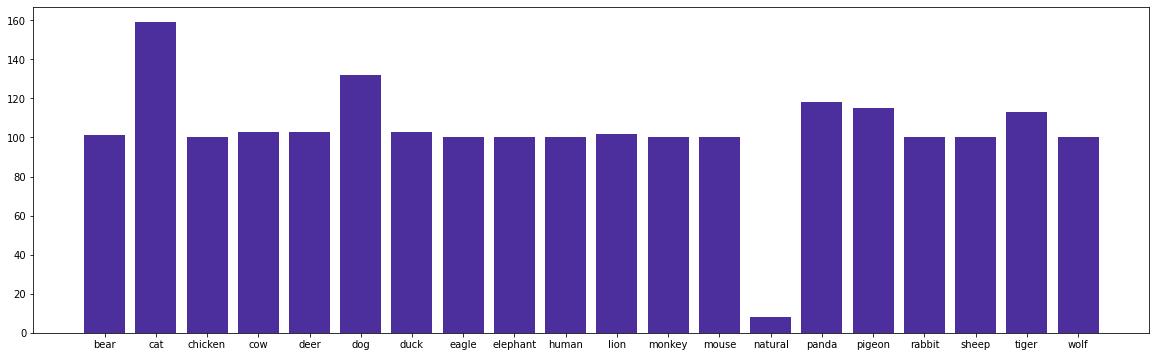

In [8]:
plt.figure(figsize=(20, 6))
plt.bar(list(count_values.keys()), count_values.values(), color='#4d2e9d')

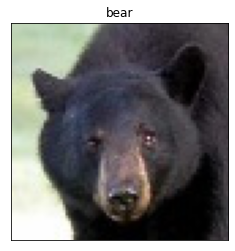

In [9]:
plt.imshow(data['data'][0])
plt.xticks([])
plt.yticks([])
plt.title(data['target'][0])
plt.show()

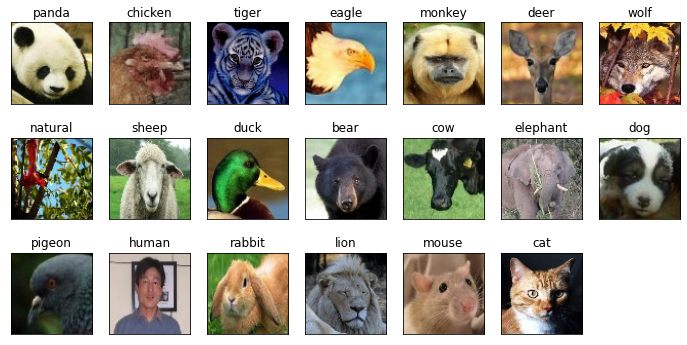

In [10]:
plt.figure(figsize=(12,6))
for idx, label in enumerate(data['labels']):
    index = data['target'].index(label)
    plt.subplot(3, 7, idx+1)
    plt.imshow(data['data'][index])
    plt.xticks([])
    plt.yticks([])
    plt.title(label)
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [12]:
import skimage
import skimage.color
import skimage.io
import skimage.feature
import skimage.transform

In [13]:
X = data['data']
y = data['target']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [15]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((1645, 80, 80, 3), (412, 80, 80, 3), 1645, 412)

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

In [17]:
class rgb2gray_transform(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])

In [18]:
X_train.shape

(1645, 80, 80, 3)

In [19]:
rgb2grayObj = rgb2gray_transform()
X_train_gray = rgb2grayObj.fit_transform(X_train)

In [20]:
X_train_gray.shape

(1645, 80, 80)

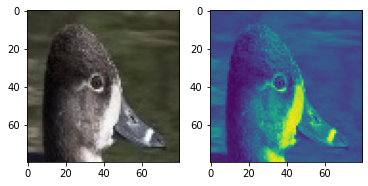

In [21]:
plt.subplot(1,2,1)
plt.imshow(X_train[10])
plt.subplot(1,2,2)
plt.imshow(X_train_gray[10])

In [22]:
class hogtransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block = (3, 3)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self.local_hog(x) for x in X])
    
    def local_hog(self, img):
        hog_feature = skimage.feature.hog(img,
                               orientations=self.orientations,
                               pixels_per_cell = self.pixels_per_cell,
                               cells_per_block = self.cells_per_block)
        return hog_feature

In [23]:
hogObj = hogtransformer()

In [24]:
X_train_hog = hogObj.fit_transform(X_train_gray)

In [25]:
X_train_hog.shape

(1645, 5184)

In [26]:
from sklearn.linear_model import SGDClassifier

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
model_sgd = SGDClassifier(loss='hinge', learning_rate='adaptive', early_stopping=True, eta0=0.1)

In [30]:
grayify = rgb2gray_transform()
hogify = hogtransformer()
scalify = StandardScaler()

In [31]:
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_scale = scalify.fit_transform(X_train_hog)
model_sgd.fit(X_train_scale, y_train)

SGDClassifier(early_stopping=True, eta0=0.1, learning_rate='adaptive')

In [32]:
X_test_gray = grayify.fit_transform(X_test)
X_test_hog = hogify.fit_transform(X_test_gray)
X_test_scale = scalify.fit_transform(X_test_hog)
y_pred_test = model_sgd.predict(X_test_scale)

In [33]:
y_pred_test

array(['dog', 'tiger', 'deer', 'cat', 'bear', 'rabbit', 'duck', 'rabbit',
       'cat', 'mouse', 'sheep', 'monkey', 'dog', 'cat', 'eagle', 'eagle',
       'duck', 'duck', 'panda', 'chicken', 'elephant', 'dog', 'monkey',
       'tiger', 'sheep', 'duck', 'dog', 'rabbit', 'deer', 'natural',
       'panda', 'tiger', 'monkey', 'bear', 'duck', 'panda', 'dog', 'dog',
       'duck', 'cat', 'sheep', 'rabbit', 'dog', 'human', 'pigeon',
       'rabbit', 'tiger', 'bear', 'cat', 'pigeon', 'panda', 'monkey',
       'cow', 'sheep', 'eagle', 'rabbit', 'panda', 'human', 'wolf', 'dog',
       'elephant', 'cat', 'elephant', 'duck', 'bear', 'cat', 'pigeon',
       'elephant', 'cat', 'panda', 'deer', 'mouse', 'human', 'human',
       'tiger', 'human', 'cow', 'elephant', 'eagle', 'monkey', 'tiger',
       'chicken', 'dog', 'wolf', 'bear', 'monkey', 'eagle', 'elephant',
       'bear', 'chicken', 'sheep', 'lion', 'bear', 'monkey', 'deer',
       'human', 'pigeon', 'bear', 'wolf', 'dog', 'deer', 'human',
     

In [34]:
cr = sklearn.metrics.classification_report(y_test, y_pred_test, output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
bear,0.444444,0.400000,0.421053,20.000000
cat,0.720000,0.562500,0.631579,32.000000
chicken,0.666667,0.500000,0.571429,20.000000
cow,0.647059,0.523810,0.578947,21.000000
deer,0.565217,0.619048,0.590909,21.000000
dog,0.518519,0.538462,0.528302,26.000000
duck,0.478261,0.523810,0.500000,21.000000
eagle,0.296296,0.400000,0.340426,20.000000
elephant,0.500000,0.550000,0.523810,20.000000
human,0.600000,0.900000,0.720000,20.000000


In [35]:
metrics.cohen_kappa_score(y_test, y_pred_test)

0.4799985078153173

In [36]:
from sklearn.pipeline import Pipeline

In [37]:
model_pipe = Pipeline([
    ('grayscale', rgb2gray_transform()), 
    ('hogtransform', hogtransformer(orientations=8, pixels_per_cell=(10, 10), cells_per_block=(3,3))),
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(loss='hinge', learning_rate='adaptive', early_stopping=True, eta0=0.1))
])

In [38]:
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('grayscale', rgb2gray_transform()),
                ('hogtransform',
                 hogtransformer(orientations=8, pixels_per_cell=(10, 10))),
                ('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(early_stopping=True, eta0=0.1,
                               learning_rate='adaptive'))])

In [39]:
y_pred_test = model_pipe.predict(X_test)
y_pred_test

array(['dog', 'tiger', 'deer', 'cat', 'monkey', 'monkey', 'tiger',
       'rabbit', 'cat', 'wolf', 'elephant', 'pigeon', 'dog', 'cat',
       'elephant', 'sheep', 'duck', 'duck', 'sheep', 'chicken', 'dog',
       'cow', 'panda', 'tiger', 'dog', 'eagle', 'dog', 'sheep', 'deer',
       'dog', 'panda', 'tiger', 'monkey', 'bear', 'duck', 'cow', 'dog',
       'dog', 'duck', 'pigeon', 'dog', 'deer', 'dog', 'sheep', 'panda',
       'monkey', 'wolf', 'cat', 'cat', 'lion', 'chicken', 'bear', 'cow',
       'sheep', 'wolf', 'tiger', 'panda', 'eagle', 'monkey', 'lion',
       'tiger', 'cat', 'elephant', 'duck', 'cat', 'dog', 'pigeon',
       'elephant', 'cat', 'panda', 'deer', 'deer', 'human', 'human',
       'tiger', 'natural', 'cow', 'elephant', 'sheep', 'monkey', 'rabbit',
       'chicken', 'elephant', 'mouse', 'mouse', 'natural', 'eagle',
       'rabbit', 'bear', 'sheep', 'cow', 'lion', 'cow', 'monkey',
       'elephant', 'human', 'pigeon', 'bear', 'wolf', 'dog', 'deer',
       'human', 'tiger

In [40]:
cr = sklearn.metrics.classification_report(y_test, y_pred_test, output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
bear,0.625000,0.250000,0.357143,20.000000
cat,0.655172,0.593750,0.622951,32.000000
chicken,0.687500,0.550000,0.611111,20.000000
cow,0.590909,0.619048,0.604651,21.000000
deer,0.619048,0.619048,0.619048,21.000000
dog,0.535714,0.576923,0.555556,26.000000
duck,0.600000,0.571429,0.585366,21.000000
eagle,0.384615,0.500000,0.434783,20.000000
elephant,0.583333,0.700000,0.636364,20.000000
human,0.761905,0.800000,0.780488,20.000000


In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
estimator = Pipeline([
    ('grayscale', rgb2gray_transform()), 
    ('hogtransform', hogtransformer()),
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier()),
])

In [43]:
param_grid = [
    {
        'hogtransform__orientations': [7,8,9,10],
        'hogtransform__pixels_per_cell': [(7,7),(8,8),(9,9),(10,10)],
        'hogtransform__cells_per_block': [(2,2),(3,3),(4,4)],
        'sgd__loss': ['hinge', 'squared_hinge', 'perceptron'],
        'sgd__learning_rate': ['optimal']
    },
    {
        'hogtransform__orientations': [7,8,9,10],
        'hogtransform__pixels_per_cell': [(7,7),(8,8),(9,9),(10,10)],
        'hogtransform__cells_per_block': [(2,2),(3,3),(4,4)],
        'sgd__loss': ['hinge', 'squared_hinge', 'perceptron'],
        'sgd__learning_rate': ['adaptive'],
        'sgd__eta0': [0.001, 0.01]
    }
]

In [44]:
model_grid = GridSearchCV(estimator = estimator, 
                         param_grid = param_grid, 
                         scoring = 'accuracy', 
                         n_jobs=-1, 
                         cv=3, 
                         verbose=2
                        )

In [45]:
# model_grid.fit(X_train, y_train)

In [46]:
# pd.DataFrame(sklearn.metrics.classification_report(y_test, model_grid.predict(X_test), output_dict=True)).T

In [50]:
import pickle

In [48]:
# with open('model.pkl', 'wb') as fl:
#     pickle.dump(model_grid, fl)

In [51]:
with open('model.pkl', 'rb') as fl:
    model_grid = pickle.load(fl)
model_grid.best_params_, model_grid.best_score_

({'hogtransform__cells_per_block': (3, 3),
  'hogtransform__orientations': 9,
  'hogtransform__pixels_per_cell': (10, 10),
  'sgd__learning_rate': 'optimal',
  'sgd__loss': 'hinge'},
 0.7288622534225023)

In [53]:
model_best = model_grid.best_estimator_
model_best.get_params()

{'memory': None,
 'steps': [('grayscale', rgb2gray_transform()),
  ('hogtransform', hogtransformer(pixels_per_cell=(10, 10))),
  ('scaler', StandardScaler()),
  ('sgd', SGDClassifier())],
 'verbose': False,
 'grayscale': rgb2gray_transform(),
 'hogtransform': hogtransformer(pixels_per_cell=(10, 10)),
 'scaler': StandardScaler(),
 'sgd': SGDClassifier(),
 'hogtransform__cells_per_block': (3, 3),
 'hogtransform__orientations': 9,
 'hogtransform__pixels_per_cell': (10, 10),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'sgd__alpha': 0.0001,
 'sgd__average': False,
 'sgd__class_weight': None,
 'sgd__early_stopping': False,
 'sgd__epsilon': 0.1,
 'sgd__eta0': 0.0,
 'sgd__fit_intercept': True,
 'sgd__l1_ratio': 0.15,
 'sgd__learning_rate': 'optimal',
 'sgd__loss': 'hinge',
 'sgd__max_iter': 1000,
 'sgd__n_iter_no_change': 5,
 'sgd__n_jobs': None,
 'sgd__penalty': 'l2',
 'sgd__power_t': 0.5,
 'sgd__random_state': None,
 'sgd__shuffle': True,
 'sgd__tol': 0.001

In [54]:
y_pred = model_best.predict(X_test)
pd.DataFrame(sklearn.metrics.classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
bear,0.791667,0.950000,0.863636,20.000000
cat,0.914286,1.000000,0.955224,32.000000
chicken,0.952381,1.000000,0.975610,20.000000
cow,1.000000,0.952381,0.975610,21.000000
deer,1.000000,1.000000,1.000000,21.000000
dog,0.960000,0.923077,0.941176,26.000000
duck,0.900000,0.857143,0.878049,21.000000
eagle,0.900000,0.900000,0.900000,20.000000
elephant,0.857143,0.900000,0.878049,20.000000
human,0.950000,0.950000,0.950000,20.000000


In [56]:
model_best.score(X_test, y_test)

0.9271844660194175

In [58]:
pickle.dump(model_best, open('model_best.pkl', 'wb'))

In [59]:
# {'hogtransform__cells_per_block': (3, 3),
#   'hogtransform__orientations': 9,
#   'hogtransform__pixels_per_cell': (10, 10),
#   'sgd__learning_rate': 'optimal',
#   'sgd__loss': 'hinge'}

In [84]:
from sklearn.pipeline import make_pipeline

In [85]:
pipeline1 = make_pipeline(rgb2gray_transform(),
                            hogtransformer(
                                orientations=10, 
                                pixels_per_cell=(8, 8), 
                                cells_per_block=(2,2)))

In [86]:
feature_vector = pipeline1.fit_transform(X_train)

In [87]:
scaler = StandardScaler()
transformed_xtrain = scaler.fit_transform(feature_vector)

In [88]:
model = SGDClassifier(learning_rate='optimal', loss='hinge', alpha=0.01, early_stopping=True)

In [89]:
model.fit(transformed_xtrain, y_train)

SGDClassifier(alpha=0.01, early_stopping=True)

In [90]:
feature_vector = pipeline1.fit_transform(X_test)
transformed_x = scaler.fit_transform(feature_vector)
y_pred_test = model.predict(transformed_x)

In [91]:
pd.DataFrame(metrics.classification_report(y_test, y_pred_test, output_dict=True)).T

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
bear,0.700000,0.700000,0.700000,20.000000
cat,0.666667,0.875000,0.756757,32.000000
chicken,0.615385,0.800000,0.695652,20.000000
cow,0.700000,0.666667,0.682927,21.000000
deer,0.826087,0.904762,0.863636,21.000000
dog,0.678571,0.730769,0.703704,26.000000
duck,0.857143,0.571429,0.685714,21.000000
eagle,0.687500,0.550000,0.611111,20.000000
elephant,0.761905,0.800000,0.780488,20.000000
human,1.000000,0.950000,0.974359,20.000000


In [92]:
pickle.dump(model, open('dsa_image_classification_sgd.pkl', 'wb'))

In [93]:
pickle.dump(scaler, open('dsa_scaler.pkl', 'wb'))